## Testing the approach from Aasmund to do the resampling, using the CARRA1 data in zarra format and the Cry Clim original data in netcdf format

In [55]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import pyproj
import pyresample
import rioxarray
import cartopy

In [2]:
# this should be CARRA1 (east?)
carra_analysis = xr.open_zarr(f"/scratch/fab0/Projects/cerise/carra_snow_data/ana_v2.zarr")

In [3]:
proj_dict = ccrs.Projection(
        proj4_params=carra_analysis.projection,
    ).to_dict()


/ec/res4/scratch/nhd/CERISE/cerise_snow_verif/.venv/lib/python3.10/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [4]:
proj = pyproj.Proj(proj_dict)

In [5]:
targetdef = pyresample.geometry.AreaDefinition(
        "model domain",
        "1",
        "1",
        projection=proj_dict,
        width=carra_analysis.x.size,
        height=carra_analysis.y.size,
        area_extent=carra_analysis.bounding_box,
    )


In [6]:
targetdef

Area ID: model domain
Description: 1
Projection ID: 1
Projection: {'R': '6371000', 'lat_0': '80', 'lat_1': '80', 'lat_2': '80', 'lon_0': '-34', 'no_defs': 'None', 'proj': 'lcc', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 800
Number of rows: 1000
Area extent: (537154.7372, -1047009.2943, 2537154.7372, 1452990.7057)

In [7]:
cryo_sample = xr.open_dataset("/ec/res4/scratch/nhd/CERISE/CRYO_NC/snowcover_daily_nh_laea-50_avhrr_201510101200.nc")

In [8]:
#carra_analysis.variables

In [9]:
# Get area that covers CARRA domain
cryo_sample.xc.size

3601

In [10]:
cryo_sample.projection

'laea'

In [11]:
cryo_sample["xc"][0].values.item()

-9000000.0

In [12]:
#cryo_sample

In [13]:
cryo_sample["Lambert_Azimuthal_Grid"].attrs

{'grid_mapping_name': 'lambert_azimuthal_equal_area',
 'longitude_of_projection_origin': np.float64(0.0),
 'latitude_of_projection_origin': np.float64(90.0),
 'false_easting': np.float64(0.0),
 'false_northing': np.float64(0.0),
 'semi_major_axis': np.int32(6378137),
 'inverse_flattening': np.float64(298.257223563),
 'proj4': '+proj=laea +ellps=WGS84 +lat_0=90 +lon_0=0'}

In [27]:
x_coords = cryo_sample.xc.values
y_coords = cryo_sample.yc.values

area_extent = [cryo_sample["xc"][0].values.item(),
               cryo_sample["yc"][0].values.item(),
               cryo_sample["xc"][-1].values.item(),
               cryo_sample["yc"][-1].values.item()
    
]

# Create AreaDefinition
nx = cryo_sample.xc.size
ny = cryo_sample.yc.size
projection = cryo_sample["Lambert_Azimuthal_Grid"].proj4
area_def = pyresample.geometry.AreaDefinition(
    area_id='lambert_azimuthal_equal_area',  # Choose a descriptive name
    description='Lambert Azimuthal Grid',
    proj_id='laea',
    projection = projection,
    #projection={
    #    'proj': 'laea',  # Lambert Azimuthal Equal Area
    #    'lat_0': cryo_sample["Lambert_Azimuthal_Grid"].attrs.get("latitude_of_projection_origin"),  # default to North pole if not specified
     #   'lon_0': cryo_sample["Lambert_Azimuthal_Grid"].attrs.get("longitude_of_projection_origin"),
    #    'ellps': 'WGS84'
    #},
    width=nx, #len(x_coords),
    height=ny, #len(y_coords),
    area_extent=area_extent
)

In [35]:
nx

3601

In [45]:
# get subarea that covers CARRA domain
xslc, yslc = area_def.get_area_slices(targetdef)
cryo_def_slc = area_def[yslc,xslc]


In [49]:
cryo_def_slc.get_boundary_lonlats

<bound method BaseDefinition.get_boundary_lonlats of Area ID: lambert_azimuthal_equal_area
Description: Lambert Azimuthal Grid
Projection ID: laea
Projection: {'ellps': 'WGS84', 'lat_0': '90', 'lon_0': '0', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 610
Number of rows: 627
Area extent: (-757289.6418, -7497.9172, 2291863.3713, -3141627.3257)>

In [54]:
#Note: printing this gives me an error, while doing the same in the original code from Asmund does not!
#cryo_def_slc

In [33]:
#cryo_slc = (cryo_sample.isel(slice(None,None,-1)).isel(x=xslc,y=yslc))

In [34]:
nn_info = pyresample.kd_tree.get_neighbour_info(
        cryo_def_slc,
        targetdef,
        radius_of_influence=2500,
        neighbours=1,
        nprocs=2,
        epsilon=100,
    )


In [35]:
x, y = targetdef.get_proj_vectors()

In [41]:
targetdef.lons

## Plotting the area definitions below. Target and what I get from selecting target from the Cryo Clim data

/ec/res4/scratch/nhd/CERISE/cerise_snow_verif/.venv/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


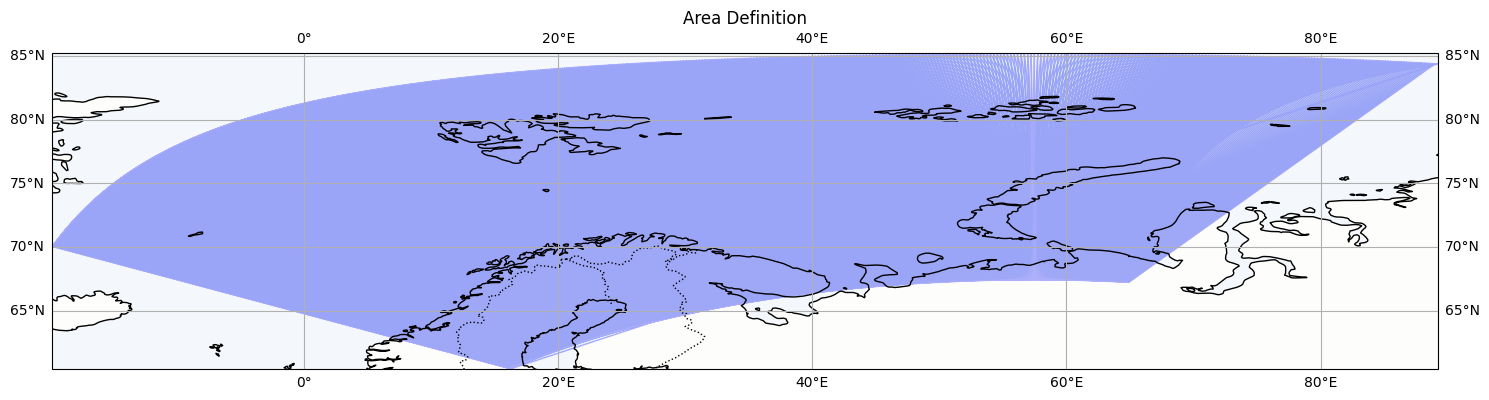

In [52]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import pyresample as pr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def plot_area_definition_shaded(area_def):
    # Get the lons and lats from the area definition
    lons, lats = area_def.get_lonlats()

    # Create a new figure with a map projection
    plt.figure(figsize=(15, 10))

    # Use PlateCarree projection or match the projection of your area definition
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.1)
    ax.add_feature(cfeature.OCEAN, alpha=0.1)

    # Create a polygon from the boundary points
    # Close the polygon by adding the first point at the end
    polygon_lons = np.append(lons.flatten(), lons.flatten()[0])
    polygon_lats = np.append(lats.flatten(), lats.flatten()[0])

    # Create a polygon patch
    polygon = Polygon(list(zip(polygon_lons, polygon_lats)),
                      closed=True,
                      edgecolor='blue',
                      facecolor='lightblue',
                      alpha=0.3,
                      transform=ccrs.PlateCarree())

    # Add the polygon to the plot
    ax.add_patch(polygon)

    # Set the map extent based on the grid boundaries
    lon_min, lon_max = np.nanmin(lons), np.nanmax(lons)
    lat_min, lat_max = np.nanmin(lats), np.nanmax(lats)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Optional: Add boundary points in red
    #plt.scatter(lons, lats, c='red', s=1, alpha=0.5, transform=ccrs.PlateCarree())
    #ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    plt.title('Area Definition')
    plt.tight_layout()
    plt.show()

# Visualize the area definition
plot_area_definition_shaded(targetdef)

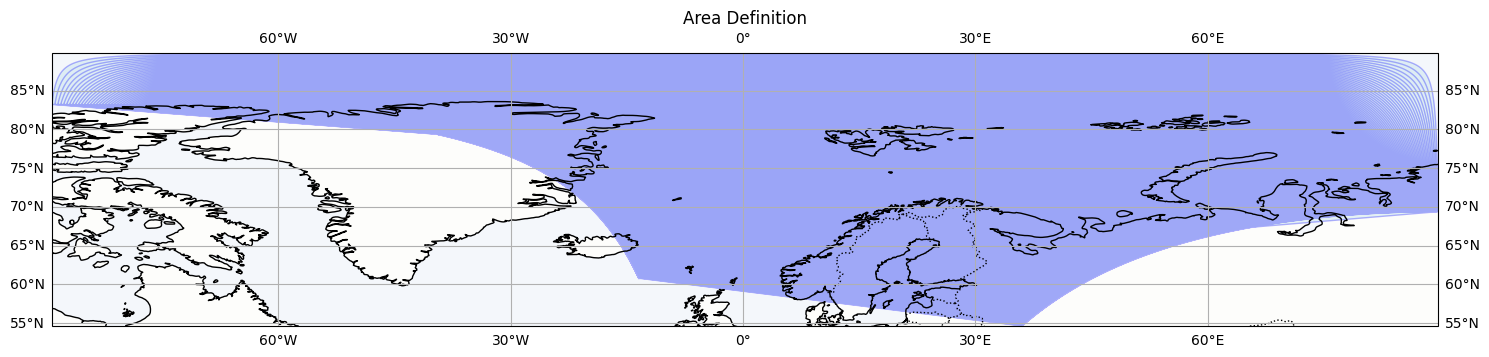

In [53]:
plot_area_definition_shaded(cryo_def_slc)

## Checking the domain is actually from CARRA1

In [47]:
carra1 = xr.open_zarr(f"/scratch/fab0/Projects/cerise/carra_snow_data/carrasnow_1991.zarr/")

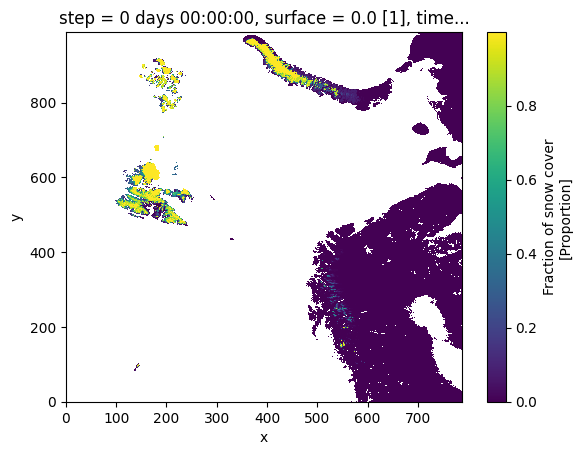

In [49]:
carra1["fscov"][0,:,:].plot()

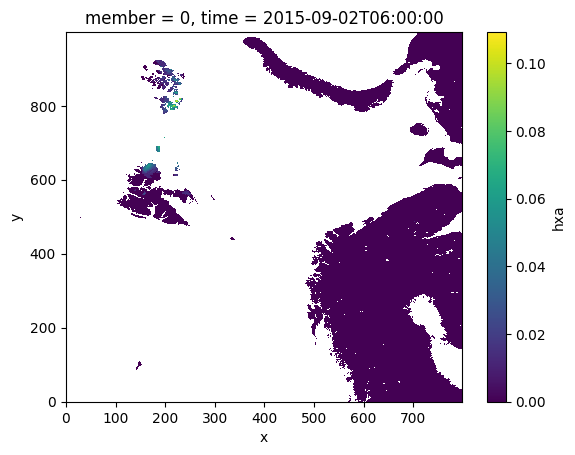

In [54]:
carra_analysis["hxa"][:,:,0,0].plot()

In [55]:
carra_analysis.bounding_box

[537154.7371957821,
 -1047009.2943193722,
 2537154.7371957824,
 1452990.7056806278]

## Testing if I can do the resampling below. 
## First going the same as Aasmund, from obs grid to CARRA1 grid

In [70]:
nn_info = pyresample.kd_tree.get_neighbour_info(
        cryo_def_slc,
        targetdef,
        radius_of_influence=2500,
        neighbours=1,
        nprocs=2,
        epsilon=100,
    )

In [72]:
#nn_info[0].shape


In [59]:
cryo_sample["prob_snow"][0,:,:].shape

(3601, 3601)

In [74]:
data_out = pyresample.kd_tree.get_sample_from_neighbour_info(
        "nn",
        targetdef.shape,
        cryo_sample["prob_snow"][0,:,:].values,
        nn_info[0],
        nn_info[1],
        nn_info[2],
        nn_info[3],
        fill_value=np.nan,
    )


ValueError: Mismatch between geometry and dataset